In [37]:
%cd /content/drive/My Drive/Datasets/Admission_Predict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.decomposition import PCA

/content/drive/My Drive/Datasets/Admission_Predict


In [38]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')

display(df.head())

display(df.info())

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


None

In [39]:
# display correlation of feature pair
display(df.corr())

# We see that all feature except Serial No. have less correlation compare to Chance of Admit (label)
# So we drop it

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,1.000000,-0.103839,-0.141696,-0.067641,-0.137352,-0.003694,-0.074289,-0.005332,0.008505
GRE Score,-0.103839,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398,0.810351
TOEFL Score,-0.141696,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012,0.792228
University Rating,-0.067641,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047,0.690132
SOP,-0.137352,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116,0.684137
LOR,-0.003694,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526,0.645365
CGPA,-0.074289,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311,0.882413
Research,-0.005332,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000,0.545871
Chance of Admit,0.008505,0.810351,0.792228,0.690132,0.684137,0.645365,0.882413,0.545871,1.000000


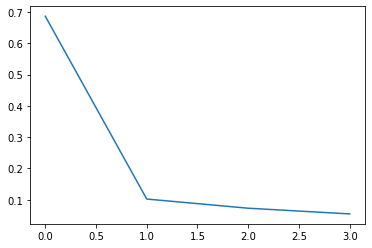

In [40]:
# Feature selection
# # drop 'Serial No.' and 'Chance of Admit ' and change to numpy array
X = df.drop(columns = ['Serial No.','Chance of Admit '])

# Label selection
# # select 'Chance of Admit ' columns and change to numpy array
y = df['Chance of Admit ']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# You need to Scaling data first before Dimensional Reduction

# Scaling on training set
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)

# Dimensional Reduction on training set 
# find n_components by select 'Elbow' in the plot
pca = PCA(n_components = 0.9)
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_)
plt.show()
# assign new PCA 
true_pca = PCA(n_components = 2)
true_pca.fit(X_train)
X_train = true_pca.transform(X_train)

# Scaling on test set using training set information (mean, std)
X_test = scale.transform(X_test)

# Dimensional Reduction on test set using traing set information
X_test = true_pca.transform(X_test)

In [41]:
Linereg = LinearRegression()
Ridreg = Ridge()
Lassreg = Lasso()

param_grid = {'alpha': [0.001, 0.01, 0.1, 1]}

Ridreg_cv = GridSearchCV(Ridreg, param_grid, n_jobs = -1)
Lassreg_cv = GridSearchCV(Lassreg, param_grid, n_jobs = -1)

Ridreg_cv.fit(X_train, y_train)
Lassreg_cv.fit(X_train, y_train)
Linereg.fit(X_train, y_train)

y_pred_rid = Ridreg_cv.predict(X_test)
y_pred_lass = Lassreg_cv.predict(X_test)
y_pred_line = Linereg.predict(X_test)

print(Ridreg_cv.best_params_)
print("Train score: {}, Test score: {}".format(Ridreg_cv.score(X_train,y_train),Ridreg_cv.score(X_test, y_test)))
print("MSE for Ridge Regression :",mean_squared_error(y_test, y_pred_rid))
print()

print(Lassreg_cv.best_params_)
print("Train score: {}, Test score: {}".format(Lassreg_cv.score(X_train, y_train),Lassreg_cv.score(X_test, y_test)))
print("MSE for Lasso Regression :",mean_squared_error(y_test, y_pred_lass),)
print()

print("Train score: {}, Test score: {}".format(Linereg.score(X_train, y_train),Linereg.score(X_test, y_test)))
print("MSE for Line Regression :",mean_squared_error(y_test,y_pred_line))

{'alpha': 1}
Train score: 0.7890938439638299, Test score: 0.7798300406744679
MSE for Ridge Regression : 0.00398128053369336

{'alpha': 0.001}
Train score: 0.7890151354422955, Test score: 0.7815602110382001
MSE for Lasso Regression : 0.003949994278246878

Train score: 0.7890941178188533, Test score: 0.7797492062024364
MSE for Line Regression : 0.0039827422440508325


In [42]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

best_estimator = Lassreg_cv.best_estimator_

lasso_Ada = AdaBoostRegressor(base_estimator=best_estimator)
param_Ada = {'learning_rate': np.arange(0.01,1.1,0.01), 'loss': ['linear', 'square', 'exponential'], 'n_estimators': np.arange(5,55,5)}
lasso_Ada_cv = RandomizedSearchCV(lasso_Ada, param_Ada, n_jobs = -1)

lasso_Ada_cv.fit(X_train, y_train)
y_pred_lasso_Ada = lasso_Ada_cv.predict(X_test)

print(lasso_Ada_cv.best_params_)
print("Train score : {}, Test score: {}".format(lasso_Ada_cv.score(X_train, y_train),lasso_Ada_cv.score(X_test, y_test)))
print("MSE for Lasso Regression + Adaboost :",mean_squared_error(y_test, y_pred_lasso_Ada))
print()

lasso_bag = BaggingRegressor(base_estimator=best_estimator)
param_bag = {'n_estimators': np.arange(5,55,5), 'max_features': np.arange(0.1,1.1,0.1), 'max_samples': np.arange(0.1,1.1,0.1)}
lasso_bag_cv = RandomizedSearchCV(lasso_bag, param_bag, n_jobs = -1)

lasso_bag_cv.fit(X_train, y_train)
y_pred_lasso_bag = lasso_bag_cv.predict(X_test)

print(lasso_bag_cv.best_params_)
print("Train score : {}, Test score: {}".format(lasso_bag_cv.score(X_train, y_train),lasso_bag_cv.score(X_test, y_test)))
print("MSE for Lasso Regression + Bagging :",mean_squared_error(y_test, y_pred_lasso_bag))


{'n_estimators': 10, 'loss': 'square', 'learning_rate': 0.03}
Train score : 0.7879586411950602, Test score: 0.7815866103051087
MSE for Lasso Regression + Adaboost : 0.0039495169066391935

{'n_estimators': 30, 'max_samples': 1.0, 'max_features': 1.0}
Train score : 0.7888651839778966, Test score: 0.7822887288216713
MSE for Lasso Regression + Bagging : 0.003936820666012636


In [43]:
from sklearn.ensemble import RandomForestRegressor

param = {'n_estimators': np.arange(100,2000,200),
        'criterion': ['mse','mae'], 
         'max_depth': np.arange(1,20,1), 
         'min_samples_split': [2,4,6,8], 
         'min_samples_leaf': np.arange(1,11,1), 
         'max_features': ['auto','sqrt','log2'],
}

rf_cv = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1), param, n_jobs = -1)
rf_cv.fit(X_train, y_train)
y_pred_rf = rf_cv.predict(X_test)

print(rf_cv.best_params_)
print("Train score: {}, Test score: {}".format(rf_cv.score(X_train, y_train),rf_cv.score(X_test, y_test)))
print("MSE for Random Forest Regression :",mean_squared_error(y_test, y_pred_rf))

{'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 16, 'criterion': 'mse'}
Train score: 0.8538806831973537, Test score: 0.7533315068518417
MSE for Random Forest Regression : 0.004460447161159793
